In [1]:
import openmm as mm
from openmm import unit as u
import numpy as np
from matplotlib import pyplot as plt

In [2]:
upper_composition={'POPC':100}
lower_composition={'POPC':100}

In [3]:
surface_area = {'POPC':68.3*u.angstroms**2} 
radius = {'POPC':4.66*u.angstroms}

In [4]:
upper_area = 0.0 * u.angstroms**2
lower_area = 0.0 * u.angstroms**2

for lipid in upper_composition:
    upper_area += upper_composition[lipid]*surface_area[lipid]

for lipid in lower_composition:
    lower_area += lower_composition[lipid]*surface_area[lipid]

In [5]:
upper_area

Quantity(value=6830.0, unit=angstrom**2)

In [6]:
lower_area

Quantity(value=6830.0, unit=angstrom**2)

In [7]:
abs(upper_area-lower_area)<30.0*u.angstroms**2

True

In [8]:
area = abs(upper_area+lower_area)/2.0

In [9]:
clearance_factor = 4.0/np.pi
clearance_factor = 1.00

In [10]:
area=area*clearance_factor

In [11]:
length_x = np.sqrt(area)
length_y = length_x

In [12]:
length_x

Quantity(value=82.64381404557754, unit=angstrom)

In [13]:
length_y

Quantity(value=82.64381404557754, unit=angstrom)

In [14]:
upper_n_lipids = np.sum(list(upper_composition.values()))
lower_n_lipids = np.sum(list(upper_composition.values()))

In [15]:
upper_n_lipids

100

In [16]:
lower_n_lipids

100

In [17]:
composition = upper_composition

discs_charge=[]*u.elementary_charge
discs_sigma=[]*u.angstrom
discs_epsilon=[]*u.kilocalories_per_mole

for lipid_name in composition:
    sigma = 0.89*(2*radius[lipid_name])
    epsilon = 0.238*u.kilocalories_per_mole # argon
    charge = 0.0*u.elementary_charge
    for ii in range(composition[lipid_name]):
        discs_charge.append(charge)
        discs_sigma.append(sigma)
        discs_epsilon.append(epsilon)

n_discs = np.sum(list(composition.values()))
        
discs_positions = np.zeros([n_discs,3], dtype=float)*u.angstroms
discs_positions[:,0] = np.random.uniform(0.0,length_x._value, n_discs)*u.angstroms
discs_positions[:,1] = np.random.uniform(0.0,length_y._value, n_discs)*u.angstroms

In [18]:
# System
system = mm.System()

# Periodic box vectors.
a = [length_x._value, 0.0, 0.0]*u.angstrom
b = [0.0, length_y._value, 0.0]*u.angstrom
c = [0.0, 0.0, 8.0*max(discs_sigma._value)]*u.angstrom

system.setDefaultPeriodicBoxVectors(a, b, c)

nb = mm.NonbondedForce()
nb.setNonbondedMethod(mm.NonbondedForce.CutoffPeriodic)
nb.setCutoffDistance(3.0*max(discs_sigma))
nb.setUseDispersionCorrection(True)

for charge, sigma, epsilon in zip(discs_charge, discs_sigma, discs_epsilon):
    system.addParticle(40.0*u.amu)
    nb.addParticle(charge, sigma, epsilon)

_ = system.addForce(nb)

In [19]:
# Add a restrining potential to keep atoms in z=0
energy_expression = 'k * (z^2)'
force = mm.CustomExternalForce(energy_expression)
force.addGlobalParameter('k', 500)
for disc_index in range(n_discs):
    force.addParticle(disc_index, [])
_ = system.addForce(force)

In [20]:
# Definición del estado termodinámico y el integrador.

step_size = 0.0005*u.picoseconds
temperature = 100*u.kelvin
friction = 1.0/u.picosecond # Damping para la dinámica de Langevin

integrator = mm.LangevinIntegrator(temperature, friction, step_size)

In [21]:
# Creación de la plataforma.

platform_name = 'CUDA'
platform = mm.Platform.getPlatformByName(platform_name)

In [22]:
# Creación del contexto.

context = mm.Context(system, integrator, platform)

In [23]:
# Condiciones iniciales

initial_positions  = np.zeros([n_discs,3], dtype=float) * u.angstrom
initial_positions[:,0] = np.random.uniform(0.0, length_x._value, n_discs) * u.angstrom
initial_positions[:,1] = np.random.uniform(0.0, length_y._value, n_discs) * u.angstrom

initial_velocities = np.zeros([n_discs, 3], np.float32) * u.angstroms/u.picoseconds

context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

In [24]:
f = context.getSystem().getForce(0)

In [25]:
def get_max_force(f):
    fmax = 0.0*f.unit**2
    for aa in f:
        mod2 = aa[0]**2+aa[1]**2+aa[2]**2
        if fmax<mod2:
            fmax=mod2
    return np.sqrt(fmax)

In [26]:
for factor in np.linspace(0.0, 1.0, num=500, endpoint=True):
    
    for index, charge, sigma, epsilon in zip(range(n_discs), discs_charge, discs_sigma, discs_epsilon):
        f.setParticleParameters(index, charge, factor*sigma, epsilon)

    f.updateParametersInContext(context)
    state = context.getState(getEnergy=True, getForces=True)
    Ep = state.getPotentialEnergy()
    max_force = get_max_force(state.getForces())

    
    if max_force>100.0*max_force.unit:
        
        print('>>>', factor, Ep, max_force)
        mm.LocalEnergyMinimizer.minimize(context)
        
        context.getIntegrator().step(50000)
        
        mm.LocalEnergyMinimizer.minimize(context)
        state = context.getState(getEnergy=True, getForces=True)
        Ep = state.getPotentialEnergy()
        max_force = get_max_force(state.getForces())
        print('  >', factor, Ep, max_force)

context.getIntegrator().step(100000)
mm.LocalEnergyMinimizer.minimize(context)

>>> 0.018036072144288574 -0.5247428418545106 kJ/mol 125.24359336875965 kJ/(nm mol)
  > 0.018036072144288574 -0.0035973234510102846 kJ/mol 0.3131286476923724 kJ/(nm mol)
>>> 0.058116232464929855 -1.6918014594882296 kJ/mol 171.03026291008882 kJ/(nm mol)
  > 0.058116232464929855 -1.3998562404483126 kJ/mol 33.147851131390766 kJ/(nm mol)
>>> 0.06212424849699398 -1.3425887675535495 kJ/mol 175.68745097008002 kJ/(nm mol)
  > 0.06212424849699398 105.58589149997117 kJ/mol 28037.222209782405 kJ/(nm mol)
>>> 0.06412825651302605 162.7433621561619 kJ/mol 41819.30060936049 kJ/(nm mol)
  > 0.06412825651302605 21734285312.0 kJ/mol 659371.500001318 kJ/(nm mol)
>>> 0.06613226452905811 21734285312.0 kJ/mol 659371.5000015851 kJ/(nm mol)
  > 0.06613226452905811 22322741248.0 kJ/mol 668260.3140383577 kJ/(nm mol)
>>> 0.06813627254509018 22322741248.0 kJ/mol 668260.3143400999 kJ/(nm mol)
  > 0.06813627254509018 0.8732990901751944 kJ/mol 39.154997907410056 kJ/(nm mol)
>>> 0.0721442885771543 0.8916708705682471 k

In [27]:
positions = context.getState(getPositions=True).getPositions(asNumpy=True)

In [28]:
def pbc_wrap(positions, length_x, length_y):
    n = positions.shape[0]
    for ii in range(n):
        x = positions[ii,0]
        lx = x/length_x
        if (lx>=1.0) or (lx<0.0):
            positions[ii,0]=x-np.floor(lx)*length_x
        y = positions[ii,1]
        ly = y/length_y
        if (ly>=1.0) or (ly<0.0):
            positions[ii,1]=y-np.floor(ly)*length_y
    return positions

In [29]:
positions = pbc_wrap(positions, length_x, length_y)

(-0.8449425089241936, 9.163673212944902, -0.859802668277896, 8.985100021939049)

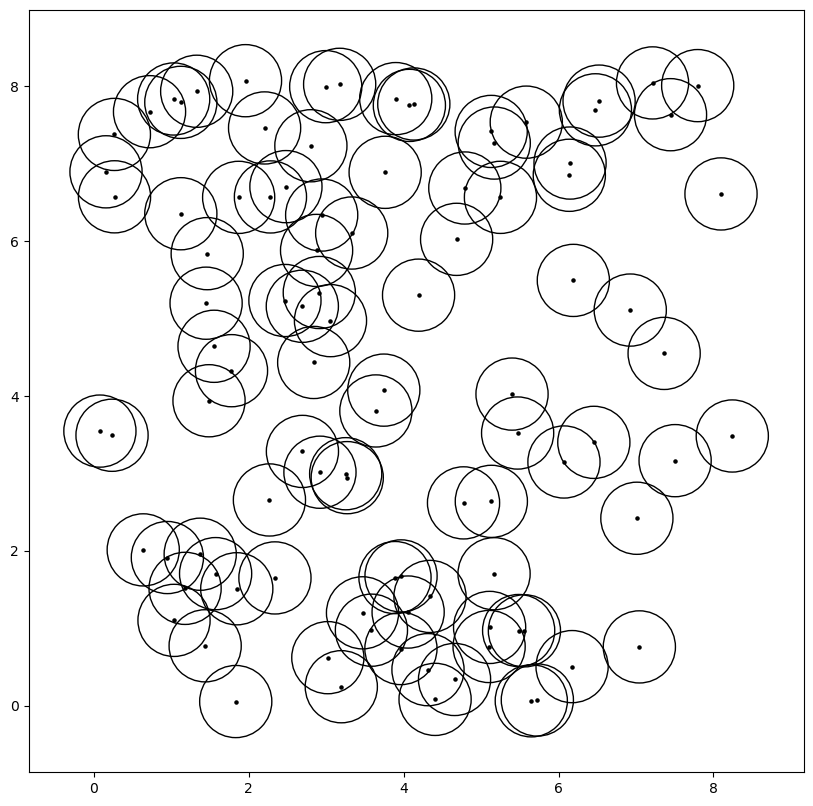

In [30]:
plt.rcParams["figure.figsize"] = (10,10)

radius = 0.466

ax=plt.gca()
for ii in range(100):
    ax.add_patch(plt.Circle(positions[ii,:]._value, radius= radius, color='k', fill=False))
    
plt.scatter(positions[:,0], positions[:,1], s=5, c='k')

plt.axis('scaled')

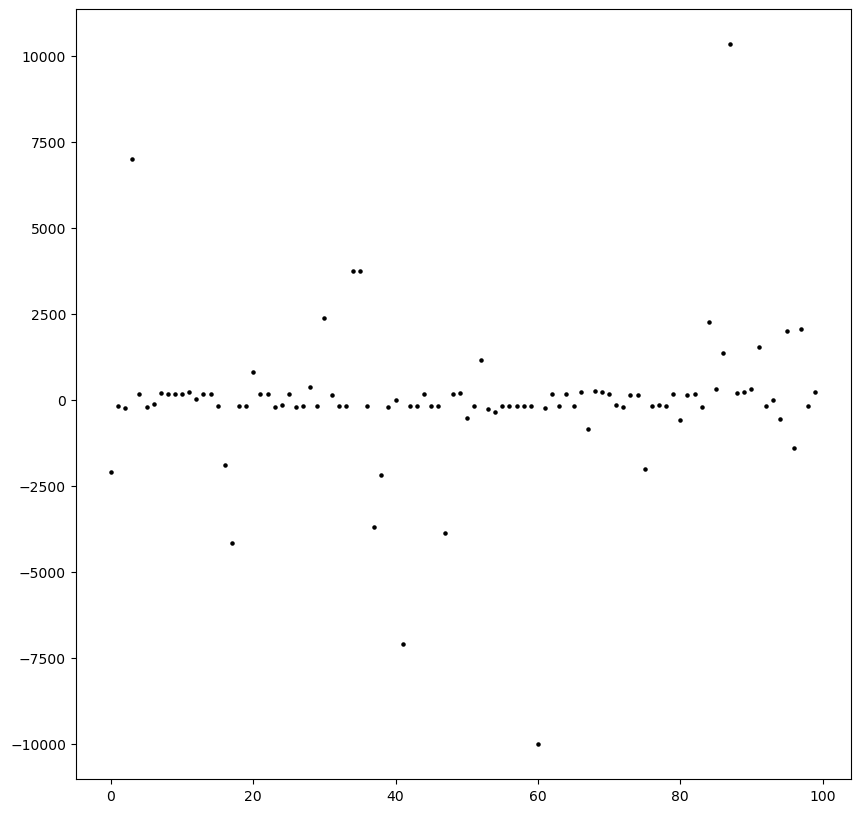

In [31]:
plt.scatter(range(n_discs), positions[:,2], s=5, c='k')